# Unscented Kalman Filters 

In [2]:
# With this backend, the output of plotting commands is displayed 
# inline within frontends, directly below the code cell that produced it
%matplotlib inline

Nonlinearity can appear in two places: in measurements or in the process model. 
In measurements the nonlinearity is due to noises too difficult and unpredictable to be considered and accurately modeled - for example, with RSSI measurements, the reflection of the signal on the walls of a building, an object obstructing two sensors or even the placement of the antennas of the sensors may change the RSSI value. 
These noises are intrinsecally nonlinear. 
Another element of nonlinearity is the process model itself for a certain phenomena. 
If we are tracking a ball traveling through the air, the effects of air drag lead to non-linear behaviour. 

The Standard Kalman Filter performs poorly or not at all with these sorts of problems as it is thought for linear optimization. 

The Extended Kalman Filter, while considering non-linear models, linearizes them by producing a Jacobian Matrix at each iteration, which is computationally expensive. 

We will now study the use of Uscented Kalman Filters.

Let's first see an example of non-linear plot, to emphasize the effects of nonlinearity. 

The definition of a nonlinear function is a function that does not graph into a straight line and does not have a constant slope, of form

 $f(x) = ax + b$

So let's first plot an example of nonlinear function

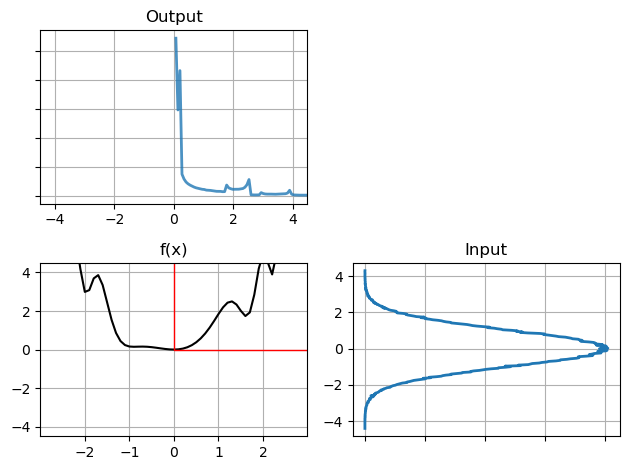

In [31]:
import matplotlib.pyplot as plt 
from numpy.random import normal, multivariate_normal
import numpy as np 
import scipy.stats 

# create 500000 samples with mean 0, std 1
gaussian = (0., 1.)
data = normal(loc = gaussian[0], scale= gaussian[1], size= 500000)

def nonlinear_function(x): 
    return x**2 + np.sin(x**3)

y_values = nonlinear_function(data)
x0 = np.mean(data)
in_std = np.std(data)

y = nonlinear_function(x0)
std = np.std(y_values)

in_lims = [x0 - in_std*3, x0 + in_std*3]
out_lims = [y - std*3, y + std*3]

# plotting output
h = np.histogram(y_values, 300, density = False)
plt.subplot(2, 2, 1)
plt.plot(h[1][1:], h[0], lw = 2, alpha=0.8)

plt.xlim(out_lims[0], out_lims[1])
plt.gca().yaxis.set_ticklabels([])
plt.grid(True)
plt.title('Output')

#plt.axvline(np.mean(y_values), ls='--', lw=2)
#plt.axline(nonlinear_function(x0), lw=1)

norm = scipy.stats.norm(y, in_std)

# plottinh the transfer function 
plt.subplot(2,2,3)
x = np.arange(in_lims[0], in_lims[1], 0.1)
y = nonlinear_function(x)

plt.plot(x, y, 'k')
isct = nonlinear_function(x0)
plt.plot([x0, x0, in_lims[1]], [out_lims[1], isct, isct], color='r', lw=1)
plt.xlim(in_lims)
plt.ylim(out_lims)
plt.grid(True)
plt.title('f(x)')

#plot input 
h = np.histogram(data, 300, density = True)

plt.subplot(2,2,4)
plt.plot(h[0], h[1][1:], lw=2)
plt.gca().xaxis.set_ticklabels([])
plt.title('Input')
plt.tight_layout()
plt.grid(True)
plt.show()



f(x) is the nonlinear transformation function chosen. 
The input follows a gaussian distribution with mean zero and the result
is computed by sampling 500000 points from the imput and builduing a 
histogram of the result. 
These points are called **sigma points**. 

From the computed output histogram we can compute a mean and 
a standard deviation which would give us an updated, approximated gaussian. 